# Image Randomizer and Classifier

This code was used to display random images from Test folder and use the model to make predictions on it and display results during Demo Day.


## Libraries

In [1]:
# Keras libraries
from keras.models import load_model
from keras.preprocessing import image

# General Purpose libraries
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import multiprocessing

import time
from IPython.display import clear_output

Using TensorFlow backend.


---

## Defining global variables

In [2]:
# Defining taret names, so it is easy to retrieve the values back
labels_string = {'c0':'Safe Driving','c1':'Text Rigth', 
                 'c2':'Phone Rigth', 'c3':'Text Left', 
                 'c4':'Phone Left', 'c5':'Adjusting Radio', 
                 'c6':'Drinking', 'c7':'Reaching Behind', 
                 'c8':'Hair or Makeup', 'c9':'Talking to Passenger'}
# Defining global image size
img_width, img_height = 640, 480

## Loading Model

The model for this project is a CNN with Transfer Learning from MobileNet (imagenet). The complete Neural Network had a total of 95 layers. 87 of them were Convolutional Layers and 8 were Fully Connected layers. With all those layers to process, the fitting process takes a lot of machine processing.

With that in mind, I needed to use a more powerful notebook, there for I created a AWS notebook to be able to run the model.

Since the Model creation is on the cloud, the last step was to save a `.h5` file with the result of the model and import it here to check accuracy one by one.


This was also used to display random images on Demo day.

In [3]:
# import model from file.
model = load_model('saved_models/20191207-0450_epochs.h5', custom_objects=labels_string)

With the model imported, I can now create a function that will predict a single image that is passed to it.

In [4]:
def plot_and_expand_image(path, img_width, img_height):
    '''
    - This function is a simple way to Plot any image of any size using Matplotlib
    -----
    INPUT
    -----
    path (String) -> Path to the image that will be displayed.
                     The path must contain the file name an extenion as well
    img_width (Int) -> Integer with the size of the image
    img_height (Int) -> Integer with the size of the image
    ------
    OUTPUT
    ------
    A NP Array with expanded dimension that will be passe to the model
    '''
    #Load Image
    img = image.load_img(path, target_size=(int(img_width/2), int(img_height/2),3))
    # Convert to Array
    x = image.img_to_array(img)
    # Rescale it (just like it was made on the Augmentation part of the CNN)
    x = x/255.

    # Using Matplotlib mpimg to map the array to a plt object
    img = mpimg.imread(path)

    # Instantiate plt
    plt.figure(figsize=(5,5))
    # Plot
    plt.imshow(img)
    # It is a image, so let's remove Axis Labels
    plt.axis('off')
    # Show plot
    plt.show()
    # Return Function
    return np.expand_dims(x, axis=0)

In [5]:
def predict_image(frame, img_width, img_height):
    '''
    - Predict_image is a function that receives a single image from a local folder and runs a prediction
    on it based on the imported model
    -----
    INPUT
    -----
    frame (String) -> Frame THE PATH to a single jpg image located on the folder. I am calling this input frame because
    later this function will be used to predict frames extracted from a webcam.
    img_width (Int) -> Integer with the size of the image
    img_height (Int) -> Integer with the size of the image
    ------
    OUTPUT
    ------
    class_df (DataFrame) -> This is a DataFrame object containing 11 columns. 
        Column 'image'-> is the local address for the image used to make a prediction
        Columns 'c0','c1','c2','c3','c4','c5','c6','c7','c8','c9' -> are the classes used to make the model
            Classes labels: 'c0':'Safe Driving'
                            'c1':'Text Rigth' 
                            'c2':'Phone Rigth'
                            'c3':'Text Left'
                            'c4':'Phone Left'
                            'c5':'Adjusting Radio'
                            'c6':'Drinking'
                            'c7':'Reaching Behind'
                            'c8':'Hair or Makeup'
                            'c9':'Talking to Passenger'
    '''
    # Create a clean instance of class_df for everytime the function is called
    class_df = pd.DataFrame(columns=['image','c0','c1','c2','c3','c4','c5','c6','c7','c8','c9'])
    # Plotting image on the screen
    x = plot_and_expand_image(frame,img_width, img_height)
    # Make prediction using Keras Model
    y_pred = model.predict(x, batch_size=10)
    # Save prediction to Data Frame
    # First save classes probabilites based on prediction
    class_df[['c0','c1','c2','c3','c4','c5','c6','c7','c8','c9']] = pd.DataFrame(y_pred[0]).T

    # Finally save Image path (For reference only)
    class_df['image'] = frame
    
    #Return DataFrame
    return class_df

## Testing Model with _SINGLE_ Test Images

Now it is time to test predictions on the Test Images available.

The **Test** folder provided by Kaggle has two issues</br>
1- The don't have lables, so I can't make a batch prediction and compare results for a Confusion Matrix or any other Metric.</br>
2- There are 75k images witch is a Processing Power issue. I would need several hours to process the prediction on all those files

To optimize this problem while I am twiking the model, I created a code that will randomly selec a image from the Test folder, display the image and display the prediction. I can then eyeball the accuracy. Once I am satisfied, I'll run the `prediction_generator` that will predict on all images, which will take a lot of time to finish.

In [6]:
def start_presentation():
    '''
    - This is the Main function on this Notebook. It is used to activate all other functions.
    -----
    INPUT
    -----
    NONE
    ------
    OUTPUT
    ------
    NONE
    '''
    
    # Create a clean instance of Prediction DataFrame
    pred = pd.DataFrame()
    
    # Run a endless Loop that will randomly select an image in the Test Folder, Display it and Predict It
    #This will run forever so it could be running over the entire Demo Day
    while True:
        # Pick randomly a single image from the test folder
        img_file_name = random.choice(os.listdir(f'data/imgs/test/test'))
        # Create a path varibale with the complete path, including file name
        path = f'data/imgs/test/test/{img_file_name}'
        # Call predict_image function and get DataFrame back
        predicted_df = predict_image(path, img_width, img_height)

        # Displaying information on screen
        # Removing Image column
        pred = predicted_df.iloc[:,1:]
        # Rounding values on the dataframe to look more like a % value
        pred_percent = round(pred*100.,2)

        # Changing column labels to be Human Readable
        # Instead of 0 and 1 we will have 'Safe Driving' and 'Text Rigth'
        pred.columns = labels_string.values()
        pred_percent.columns = labels_string.values()
        # Identifying class with biggest weight
        maxValue = pred.T[:].reset_index()[0].idxmax()

        # Print on screen
        print('------------------------------------------------')
        print('')
        print(f'Predicted Action: {pred.columns[maxValue]}')
        print(f'Probability: {round(pred.iloc[0,maxValue]*100,2)}%')
        print('')
        print('------------------------------------------------')
        print('')
        print(f'Probability Table for each class:')
        display(pred_percent.round(2))
        
        # Increment Counter
        i = 0
        # Clock code
        # Count 20 seconds and start process again with new image
        while i < 20:
            time.sleep(1)
            i+= 1
        # Clear all outputs on the notebook, making space for the next image
        clear_output()

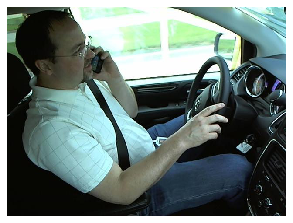

------------------------------------------------

Predicted Action: Phone Left
Probability: 85.59%

------------------------------------------------

Probability Table for each class:


,Safe Driving,Text Rigth,Phone Rigth,Text Left,Phone Left,Adjusting Radio,Drinking,Reaching Behind,Hair or Makeup,Talking to Passenger
0,0.42,0.27,3.17,0.37,85.589996,0.41,1.0,0.03,8.63,0.11


In [ ]:
# Start presentation
start_presentation()